# Setup

In [1]:
import sys
import anndata
from scipy.sparse import csr_matrix

# the path to the scVI github repo https://github.com/YosefLab/scVI
# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('/home/angela/src/scVI_TSP/')
# the path to tabulasapiens github repo https://github.com/czbiohub/tabula-sapiens
# sys.path.append('/data/yosef2/users/chenling/tabula-sapiens/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

# if a model has been trained load pretrained model rather than retraining
retrain=False


/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import matplotlib
%matplotlib inline

In [3]:
# data_path = '/data/yosef2/users/chenling/TabulaSapiensData/'
# model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/combined/'
# res_path = '/data/yosef2/users/chenling/TabulaSapiens/Combined'

# if not os.path.exists(model_path):
#     os.mkdir(model_path)
# if not os.path.exists(model_path+'scanvi/'):
#     os.mkdir(model_path+'scanvi/')
# if not os.path.exists(res_path):
#     os.mkdir(res_path)
    
    
data_path = '/mnt/ibm_lg/angela/sapiens/data/'
model_path = '/mnt/ibm_lg/angela/sapiens/data/scVI_models/'
res_path = '/mnt/ibm_lg/angela/sapiens/data/'

# Read data

In [5]:
combined = read_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id_Jun29.h5ad')
# combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.h5ad')

In [6]:
ss2_index = combined.obs.loc[combined.obs['method']=='smartseq2'].index
len(ss2_index)

12497

In [8]:
# txlen = pd.read_csv(data_path + 'homo.gencode.v30.annotation.ERCC92.iso_length.txt', delimiter='\t')

# combined.var['len'] = 0
# txlen = pd.read_csv(data_path + 'homo.gencode.v30.annotation.ERCC92.iso_length.txt', delimiter='\t')
# for x in np.unique(txlen['gene']):
#     isolen = txlen.loc[txlen['gene']==x,'length'].values.astype(int)
#     if x in combined.var.index:
#         combined.var.loc[x,'len'] = np.mean(isolen)


In [8]:
# combined.var.to_csv(data_path + 'combined/combined.var.csv')

# Normalize smartseq2 reads/length

In [10]:
var = pd.read_csv('ss2.var.csv',index_col=0)
assert np.sum(var.index == combined.var.index) == var.shape[0]
med_len = np.median(var['len'])

In [11]:
rand = np.arange(0, np.sum(combined.obs['method']=='smartseq2'),500)

In [12]:
temp = combined[combined.obs['method']=='smartseq2'].X[rand]

In [13]:
for i,x in enumerate(ss2_index):
    a = np.asarray(combined[x].X.todense()).ravel()
    b = (a[a>0]/var.loc[a>0,'len'].values*med_len).astype(int)
    combined[x,var.loc[a>0].index].X = b

In [14]:
temp2 = combined[combined.obs['method']=='smartseq2'].X[rand]

In [15]:
for i in range(len(rand)):
    a = np.asarray(temp[i].todense()).ravel()
    b = np.asarray(temp2[i].todense()).ravel()
    assert (np.sum((a/var['len'].values*med_len).astype(int)==b)) == len(a)

In [16]:
var.head()

,feature_types-0,gene_symbol-0,ensembls-1,query-1,_id-1,_score-1-0,entrezgene-1,name-1-0,taxid-1,notfound-1,n_cells-1-0,gene_symbol-1-0,_score-1-1,name-1-1,n_cells-1-1,gene_symbol-1-1,len
ENSG00000223972.5,Gene Expression,DDX11L1,ENSG00000223972,ENSG00000223972,ENSG00000223972,28.898235,NaN,DEAD/H-box helicase 11 like 1,9606.0,NaN,5,DDX11L1,28.912962,DEAD/H-box helicase 11 like 1,0,DDX11L1,1144.5
ENSG00000227232.5,Gene Expression,WASH7P,ENSG00000227232,ENSG00000227232,ENSG00000227232,10.178344,NaN,"WASP family homolog 7, pseudogene",9606.0,NaN,65,WASH7P,10.174388,"WASP family homolog 7, pseudogene",0,WASH7P,1351.0
ENSG00000278267.1,Gene Expression,MIR6859-1,ENSG00000278267,ENSG00000278267,ENSG00000278267,32.521180,NaN,microRNA 6859-1,9606.0,NaN,3,MIR6859-1,32.540504,microRNA 6859-1,64,MIR6859-1,68.0
ENSG00000243485.5,Gene Expression,MIR1302-2HG,ENSG00000243485,ENSG00000243485,ENSG00000243485,30.583565,NaN,MIR1302-2 host gene,9606.0,NaN,8,MIR1302-2HG,30.603180,MIR1302-2 host gene,4,MIR1302-2HG,623.5
ENSG00000284332.1,Gene Expression,MIR1302-2,ENSG00000284332,ENSG00000284332,ENSG00000284332,32.521130,NaN,microRNA 1302-2,9606.0,NaN,1,MIR1302-2,32.539940,microRNA 1302-2,2,MIR1302-2,138.0


In [17]:
combined.var

,feature_types-0-0,n_cells-0-0,gene_symbol-0-0,n_cells-1-0,n_cells-0,feature_types-0-0-1,gene_symbol-0-0-1,n_cells-1-0-1,n_cells-1-1,n_cells
ENSG00000223972.5,Gene Expression,0,DDX11L1,2,2,Gene Expression,DDX11L1,21,25,50
ENSG00000227232.5,Gene Expression,1,WASH7P,529,529,Gene Expression,WASH7P,598,795,1946
ENSG00000278267.1,Gene Expression,0,MIR6859-1,7,7,Gene Expression,MIR6859-1,6,8,21
ENSG00000243485.5,Gene Expression,0,MIR1302-2HG,4,4,Gene Expression,MIR1302-2HG,7,7,19
ENSG00000284332.1,Gene Expression,0,MIR1302-2,0,0,Gene Expression,MIR1302-2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,Gene Expression,19450,MT-ND6,3662,23087,Gene Expression,MT-ND6,3344,3815,114054
ENSG00000210194.1,Gene Expression,169,MT-TE,1289,1446,Gene Expression,MT-TE,502,512,3070
ENSG00000198727.2,Gene Expression,43309,MT-CYB,4070,47347,Gene Expression,MT-CYB,3621,4116,202843
ENSG00000210195.2,Gene Expression,2170,MT-TT,2,2172,Gene Expression,MT-TT,5,2,12019


In [29]:
combined.write_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id.june29.ss2_norm.2.h5ad')

... storing 'donor_tech_tissue' as categorical


In [ ]:
# combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june26.ss2_norm.2.h5ad')

# Test1: scVI with batch==donor

notes: lower learning rate to 1e-4, increase kl_warmup epochs from 10 to 30

[2020-06-29 14:39:29,307] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-29 14:39:29,323] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-29 14:39:36,259] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-29 14:39:38,428] INFO - scvi.dataset.dataset | Downsampled from 204082 to 204082 cells


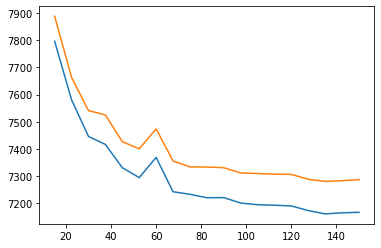

In [18]:
train_data = scVIdata_preprocess(combined, batch_col='donor', label_col='tissue')

posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.10X.donor.50.3.ss2_norm.scVI.2.pkl', 
                               retrain=retrain, n_latent=50, n_layers=3,
                               n_epochs=100, n_epochs_kl_warmup=30)


In [19]:
latent = posterior.get_latent()
combined.obsm['X_scvi'] = latent[0]
sc.pp.neighbors(combined, n_neighbors=100, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech.100'] = combined.obsm['X_umap']
combined.obsm['X_scvi_donor_tech'] = combined.obsm['X_scvi']

In [20]:
sc.pp.neighbors(combined, n_neighbors=200, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech.200'] = combined.obsm['X_umap']

In [21]:
sc.pp.neighbors(combined, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech.50'] = combined.obsm['X_umap']

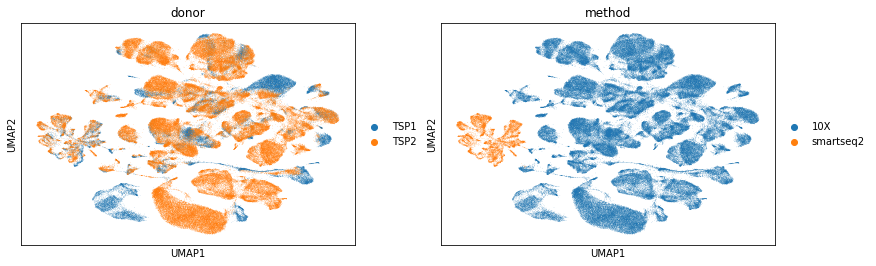

In [24]:
sc.pl.umap(combined, color=['donor','method'])

In [23]:
combined.write_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id.june29.embedding.h5ad')

# Test2: scVI with batch==donor+technology+tissue

In [93]:
# delete after running
model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/combined/'

In [26]:
donor_tech_tissue = combined.obs[['donor','method','tissue']].apply(lambda x:"_".join(x), axis=1)
combined.obs['donor_tech_tissue'] = donor_tech_tissue

In [27]:
set(combinedned.obs['donor_tech_tissue'])

{'TSP1_10X_Bladder',
 'TSP1_10X_Blood',
 'TSP1_10X_Lung',
 'TSP1_10X_Muscle',
 'TSP1_10X_Pancreas',
 'TSP1_smartseq2_Bladder',
 'TSP1_smartseq2_Blood',
 'TSP1_smartseq2_Lung',
 'TSP1_smartseq2_Muscle',
 'TSP1_smartseq2_Pancreas',
 'TSP2_10X_Bladder',
 'TSP2_10X_Blood',
 'TSP2_10X_Bone_Marrow',
 'TSP2_10X_Fat',
 'TSP2_10X_Heart',
 'TSP2_10X_Kidney',
 'TSP2_10X_Large_Intestine',
 'TSP2_10X_Lung',
 'TSP2_10X_Lymph_Node',
 'TSP2_10X_Muscle',
 'TSP2_10X_Skin',
 'TSP2_10X_Small_Intestine',
 'TSP2_10X_Spleen',
 'TSP2_10X_Thymus',
 'TSP2_10X_Trachea',
 'TSP2_10X_Vasculature',
 'TSP2_smartseq2_Bladder',
 'TSP2_smartseq2_Blood',
 'TSP2_smartseq2_Bone_Marrow',
 'TSP2_smartseq2_Kidney',
 'TSP2_smartseq2_Large_Intestine',
 'TSP2_smartseq2_Lung',
 'TSP2_smartseq2_Lymph_Node',
 'TSP2_smartseq2_Muscle',
 'TSP2_smartseq2_Skin',
 'TSP2_smartseq2_Small_Intestine',
 'TSP2_smartseq2_Spleen',
 'TSP2_smartseq2_Thymus',
 'TSP2_smartseq2_Trachea',
 'TSP2_smartseq2_Vasculature'}

[2020-06-29 19:06:54,743] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-29 19:06:54,753] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-29 19:07:01,080] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-29 19:07:02,755] INFO - scvi.dataset.dataset | Downsampled from 204082 to 204082 cells


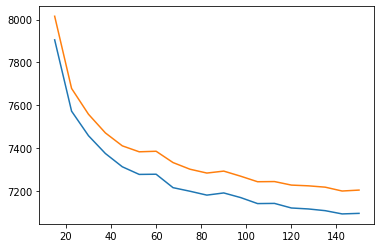

In [31]:
train_data = scVIdata_preprocess(combined, batch_col='donor_tech_tissue', label_col='tissue')

posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.all.donor_tech_tissue.50.3.ss2_norm.scVI.pkl', 
                               retrain=retrain, n_latent=50, n_layers=3,
                               n_epochs=100, n_epochs_kl_warmup=30)


In [32]:
latent = posterior.get_latent()
combined.obsm['X_scvi'] = latent[0]

In [ ]:
sc.pp.neighbors(combined, n_neighbors=100, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech_tissue.100'] = combined.obsm['X_umap']
combined.obsm['X_scvi_donor_tech_tissue'] = combined.obsm['X_scvi']

In [ ]:
sc.pp.neighbors(combined, n_neighbors=200, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech_tissue.200'] = combined.obsm['X_umap']

In [34]:
sc.pp.neighbors(combined, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech_tissue.50'] = combined.obsm['X_umap']

In [ ]:
np.unique(combined.obs['method'],return_counts=True)

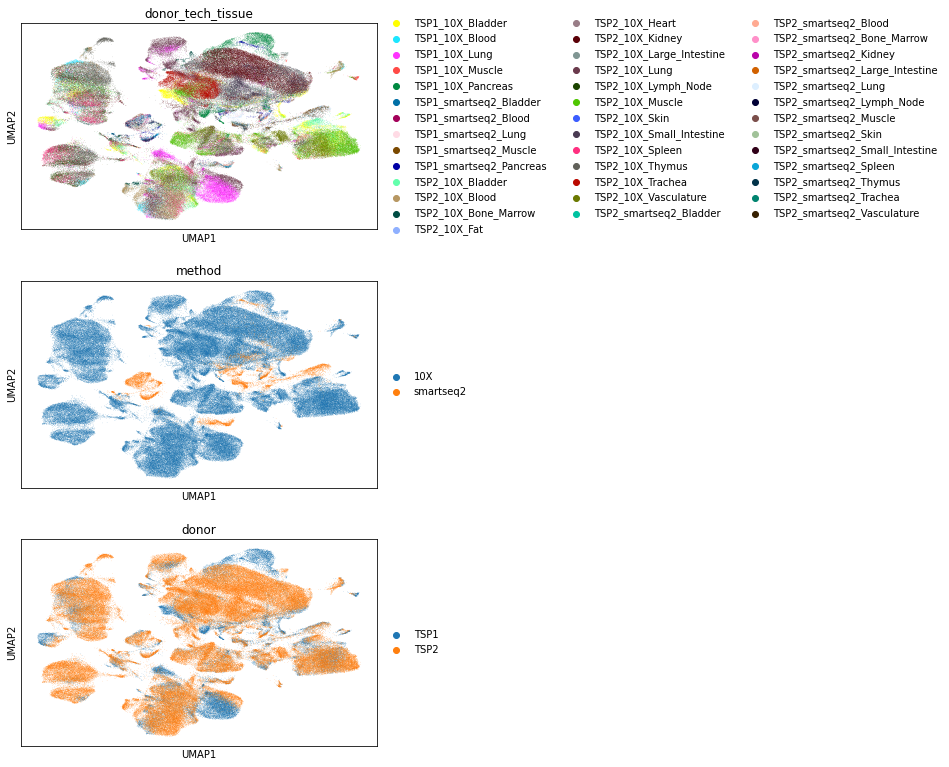

In [36]:
sc.pl.umap(combined, color=['donor_tech_tissue','method','donor'],ncols=1)

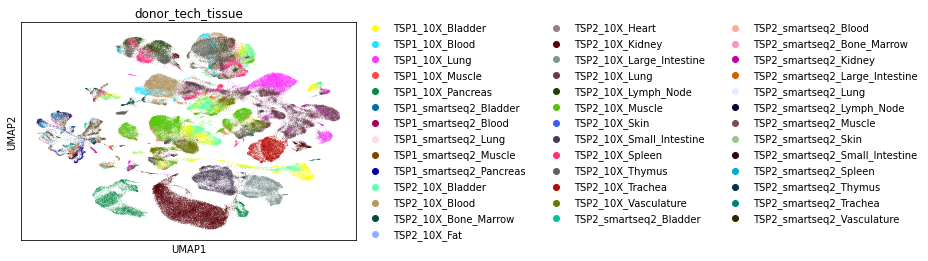

In [33]:
sc.pl.umap(combined, color=['donor_tech_tissue'])

In [ ]:
combined.write_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id.june26.ss2_norm.embedding_donor_tech_tissue.h5ad')

In [109]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june26.ss2_norm.embedding_donor_tech_tissue.h5ad')

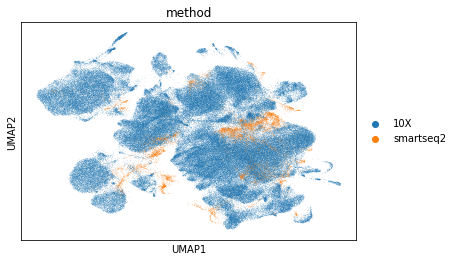

In [110]:
sc.pl.umap(combined, color=['method'])

# Test3: scVI with batch==method

[2020-06-28 07:11:38,482] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-28 07:11:38,494] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-28 07:12:01,081] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-28 07:12:09,299] INFO - scvi.dataset.dataset | Downsampled from 204804 to 204804 cells


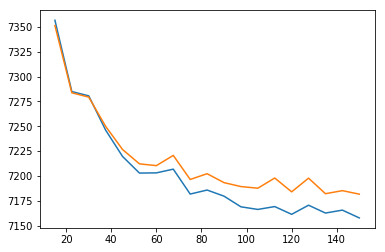

In [101]:
train_data = scVIdata_preprocess(combined, batch_col='method', label_col='tissue')

posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.all.tech.50.3.ss2_norm.scVI.pkl', 
                               retrain=retrain, n_latent=50, n_layers=3,
                               n_epochs=100)


In [102]:
latent = posterior.get_latent()
combined.obsm['X_scvi'] = latent[0]
sc.pp.neighbors(combined, n_neighbors=100, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_tech.100'] = combined.obsm['X_umap']
combined.obsm['X_scvi_tech'] = combined.obsm['X_scvi']

In [103]:
sc.pp.neighbors(combined, n_neighbors=200, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_tech.200'] = combined.obsm['X_umap']

In [104]:
sc.pp.neighbors(combined, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_tech.50'] = combined.obsm['X_umap']

In [105]:
np.unique(combined.obs['method'],return_counts=True)

(array(['10X', 'smartseq2'], dtype=object), array([191716,  13088]))

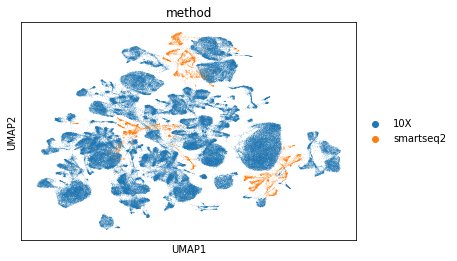

In [107]:
sc.pl.umap(combined, color=['method'])

In [ ]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june26.ss2_norm.embedding_tech.h5ad')

In [40]:
combined.X[100:110,100:110].todense()

matrix([[0., 0., 0., 2., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 2., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 4., 0., 2., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Test: bbknn for batch correction

In [41]:
adata = combined.copy()
adata.layers["counts"] = adata.X.copy()

umap computing


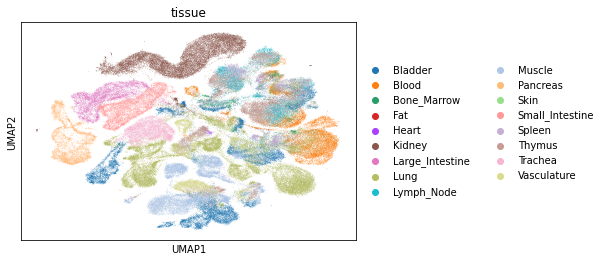

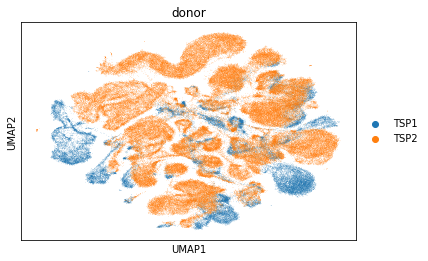

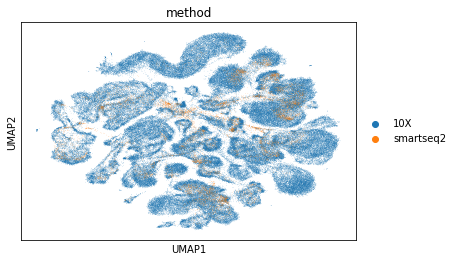

In [46]:
adata.X = adata.layers["counts"].copy()
print('normalization & scaling')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                          min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                          log=True, copy=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10, zero_center=False)
# adata.uns['tissue_colors'] = list(tissue_color_dict.values())


print('pca')
sc.tl.pca(adata,svd_solver='arpack')
sc.pl.pca_overview(adata)


print('neighs')
# sc.pp.neighbors(adata)
sc.external.pp.bbknn(adata, 
                      batch_key='method', 
                      approx=True, metric='angular',
                      n_pcs=50, trim=None, n_trees=10, 
                      use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=1)

print('umap computing')
sc.tl.umap(adata,n_components=2)
# adata.obs['tissue_FACS_droplet'] = adata.obs['tissue'].copy()
# adata.obs.loc[adata.obs['tissue'] == 'Heart_and_Aorta','tissue'] = 'Heart'
# adata.obs['tissue'] = adata.obs['tissue'].astype(str)
# adata.uns['age_colors'] = list(age_color_dict.values())
# adata.uns['tissue_colors'] = list(tissue_color_dict.values())
# adata.uns['method_colors'] = list(methods_color_dict.values())
sc.pl.umap(adata,color='tissue')#,projection='3d',save='_maca_facs_3d_tissue.pdf')
sc.pl.umap(adata,color='donor')#,projection='3d', save='_maca_facs_3d_age.pdf')
sc.pl.umap(adata,color='method')#,projection='3d', save='_maca_facs_3d_age.pdf')

# print('clustering')
# sc.tl.louvain(adata)#, resolution = 5)
# sc.tl.leiden(adata)#, resolution = 5)

# sc.pl.umap(adata,color=['louvain'], legend_loc='on data')

In [49]:
adata.var['ensembl.id'] = adata.var_names
adata.var = adata.var.set_index('gene_symbol-0-0')

adata.var

,feature_types-0-0,n_cells-0-0,n_cells-1-0,n_cells-0,feature_types-0-0-1,gene_symbol-0-0-1,n_cells-1-0-1,n_cells-1-1,n_cells,means,dispersions,dispersions_norm,highly_variable,ensembl.id
gene_symbol-0-0,,,,,,,,,,,,,,
DDX11L1,Gene Expression,0,2,2,Gene Expression,DDX11L1,21,25,50,7.288038e-05,1.234582,-0.156733,False,ENSG00000223972.5
WASH7P,Gene Expression,1,529,529,Gene Expression,WASH7P,598,795,1946,2.409826e-03,2.614616,0.854499,False,ENSG00000227232.5
MIR6859-1,Gene Expression,0,7,7,Gene Expression,MIR6859-1,6,8,21,3.753770e-05,-0.455334,-1.395034,False,ENSG00000278267.1
MIR1302-2HG,Gene Expression,0,4,4,Gene Expression,MIR1302-2HG,7,7,19,1.997979e-04,2.738720,0.945438,False,ENSG00000243485.5
MIR1302-2,Gene Expression,0,0,0,Gene Expression,MIR1302-2,0,0,0,1.000000e-12,NaN,NaN,False,ENSG00000284332.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,Gene Expression,19450,3662,23087,Gene Expression,MT-ND6,3344,3815,114054,1.459846e+00,3.151938,0.616719,True,ENSG00000198695.2
MT-TE,Gene Expression,169,1289,1446,Gene Expression,MT-TE,502,512,3070,3.633991e-02,4.111988,1.951712,True,ENSG00000210194.1
MT-CYB,Gene Expression,43309,4070,47347,Gene Expression,MT-CYB,3621,4116,202843,5.162035e+00,5.606116,-0.707107,False,ENSG00000198727.2


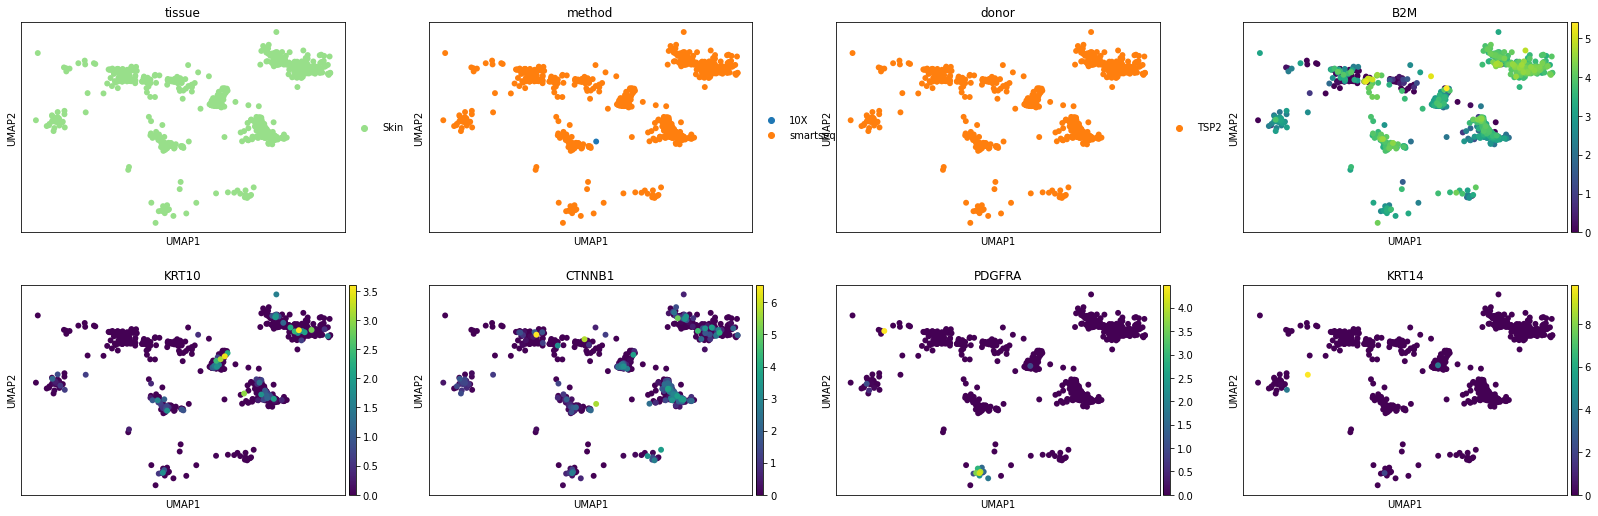

In [51]:
sc.pl.umap(
    adata[adata.obs['tissue'].isin(['Skin'])],
    color=['tissue','method','donor','B2M','KRT10','CTNNB1','PDGFRA','KRT14'])

In [52]:
adata

AnnData object with n_obs × n_vars = 204082 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'notes', 'donor', 'smartseq2_sorted_population', '10X_replicate', '10X_sample', 'sequencer', 'sex', 'anatomical_position', 'tissue', 'smartseq2_well_seq', '10X_barcode', 'n_counts', 'n_genes', 'batch', 'donor_tech_tissue'
    var: 'feature_types-0-0', 'n_cells-0-0', 'n_cells-1-0', 'n_cells-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'n_cells-1-0-1', 'n_cells-1-1', 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'ensembl.id'
    uns: 'neighbors', 'umap', 'donor_colors', 'method_colors', 'donor_tech_tissue_colors', 'log1p', 'pca', 'tissue_colors'
    obsm: 'X_scvi', 'X_umap', 'UMAP_donor_tech.100', 'X_scvi_donor_tech', 'UMAP_donor_tech.200', 'UMAP_donor_tech.50', 'UMAP_donor_tech_tissue.50', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [53]:
combined

AnnData object with n_obs × n_vars = 204082 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'notes', 'donor', 'smartseq2_sorted_population', '10X_replicate', '10X_sample', 'sequencer', 'sex', 'anatomical_position', 'tissue', 'smartseq2_well_seq', '10X_barcode', 'n_counts', 'n_genes', 'batch', 'donor_tech_tissue'
    var: 'feature_types-0-0', 'n_cells-0-0', 'gene_symbol-0-0', 'n_cells-1-0', 'n_cells-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'n_cells-1-0-1', 'n_cells-1-1', 'n_cells'
    uns: 'neighbors', 'umap', 'donor_colors', 'method_colors', 'donor_tech_tissue_colors'
    obsm: 'X_scvi', 'X_umap', 'UMAP_donor_tech.100', 'X_scvi_donor_tech', 'UMAP_donor_tech.200', 'UMAP_donor_tech.50', 'UMAP_donor_tech_tissue.50'